In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict 
import redis

import sys
import paths
sys.path.append(paths.scripts_root)
import util

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

print("Paths:")
for k,v in paths.path.items():
    print(" path.%s: %s" % (k,v))

# from Yesh's DIF_IP script
from pixval import Formatter
import blob_utils as bu
from enum import IntEnum
from skimage import measure

green = (0, 255, 0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Paths:
 path.projects_root: /Users/trafferty/data/projects
 path.images_root: /Users/trafferty/data/images
 path.results_root: /Users/trafferty/data/results
 path.ws_dir: /Users/trafferty/workspace
 path.scripts_root: /Users/trafferty/data/scripts
 path.tmp_dir: /Users/trafferty/tmp
 path.notebook_root: /Users/trafferty/data/notebooks
 path.tmp_root: /Users/trafferty/data/tmp


In [4]:
r = redis.StrictRedis(host='localhost', port=6379, db=0, decode_responses=True)

In [5]:
def zminmaxscore(r, key):
    try:
        min = r.zrangebyscore(key, '-inf', '+inf', withscores=True, start=1, num=1)[0][1]
        max = r.zrevrangebyscore(key, '+inf', '-inf', withscores=True, start=1, num=1)[0][1]
        return (min, max)
    except Exception as e:
        print( str(e) )
        return tuple()

# utils specific to DIF
#
def parseExpRoot(hash_in):
    # expRoot: "ExperimentID":run_num:"HeadSerialNumber":"NozzleSize":"MonomerID"
    return ':'.join(hash_in.split(':')[0:5])


In [7]:
completed_list = list(r.smembers('experiments_completed'))
exp_root = completed_list[0]
vel_hash = "%s:res_vel_set" % (exp_root)
volume_hash = "%s:res_vol_set" % (exp_root)

print (vel_hash)
print (volume_hash)

2017-10-02_08.42.46:1:SNX1227354:14:FF031A:res_vel_set
2017-10-02_08.42.46:1:SNX1227354:14:FF031A:res_vol_set


In [126]:
vol_min_max = zminmaxscore(r, volume_hash)
vel_min_max = zminmaxscore(r, vel_hash)

bin_cnt = 30
vol_bin_range = vol_min_max[1] - vol_min_max[0]
vol_bin_size = vol_bin_range /  bin_cnt
vel_bin_range = vel_min_max[1] - vel_min_max[0]
vel_bin_size  = vel_bin_range /  bin_cnt

print("Velocity min: %f, max: %f" % (vel_min_max[0], vel_min_max[1]))
print("Volume min  : %f, max: %f" % (vol_min_max[0], vol_min_max[1]))

Velocity min: 0.624399, max: 12.625871
Volume min  : 0.248978, max: 1.286535


In [321]:
def filter_list_of_res_by_nozzle(result_list, nozzle_of_interest):
    nozzle_filter = "res:1:%d:" % nozzle_of_interest
    filtered_results = []
    for res in result_list:
        if res[0].find(nozzle_filter) > -1:
            filtered_results.append(res)
    return filtered_results

In [346]:
nozzle_of_interest = 250

vol_bin_sets = []
vol_bin_ranges = []
vol_hist_bins = []
vol_bin_set_counts = []
vol_cnt = 0
print("Volume bins:")
for idx in range(bin_cnt):
    low = vol_min_max[0]+(idx*vol_bin_size)
    high = low + vol_bin_size
    zrange_lst = r.zrangebyscore(volume_hash, low, high, withscores=True)
    
    zrange_lst_filtered = filter_list_of_res_by_nozzle(zrange_lst, nozzle_of_interest)
    
    vol_cnt += len(zrange_lst_filtered)
    vol_hist_bins.append( low+((high-low)/2.0)  )
    vol_bin_ranges.append( (low, high) )
    vol_bin_sets.append( zrange_lst_filtered )
    vol_bin_set_counts.append( len(zrange_lst_filtered) )
    print(" low = %f, high = %f, count=%d" % (low, high, len(zrange_lst_filtered)) )
print("Volume total: %d\n-----------------------------------------" % (vol_cnt))
#vol_hist_bins.append(high)

vel_bin_sets = []
vel_bin_ranges = []
vel_hist_bins = []
vel_bin_set_counts = []
vel_cnt = 0
print("Velocity bins:")
for idx in range(bin_cnt):
    low = vel_min_max[0]+(idx*vel_bin_size)
    high = low + vel_bin_size
    zrange_lst = r.zrangebyscore(vel_hash, low, high, withscores=True)
    
    zrange_lst_filtered = filter_list_of_res_by_nozzle(zrange_lst, nozzle_of_interest)
    
    vel_cnt += len(zrange_lst_filtered)
    vel_hist_bins.append(low+((high-low)/2.0))
    vel_bin_ranges.append( (low, high) )
    vel_bin_sets.append( zrange_lst_filtered )
    vel_bin_set_counts.append( len(zrange_lst_filtered) )
    print(" low = %f, high = %f, count=%d" % (low, high, len(zrange_lst_filtered)) )
print("Velocity total: %d\n-----------------------------------------" % (vel_cnt))
#vel_hist_bins.append(high)

Volume bins:
 low = 0.248978, high = 0.283563, count=120
 low = 0.283563, high = 0.318148, count=153
 low = 0.318148, high = 0.352734, count=158
 low = 0.352734, high = 0.387319, count=112
 low = 0.387319, high = 0.421904, count=94
 low = 0.421904, high = 0.456489, count=61
 low = 0.456489, high = 0.491075, count=40
 low = 0.491075, high = 0.525660, count=40
 low = 0.525660, high = 0.560245, count=33
 low = 0.560245, high = 0.594830, count=27
 low = 0.594830, high = 0.629416, count=43
 low = 0.629416, high = 0.664001, count=37
 low = 0.664001, high = 0.698586, count=32
 low = 0.698586, high = 0.733171, count=20
 low = 0.733171, high = 0.767756, count=16
 low = 0.767757, high = 0.802342, count=10
 low = 0.802342, high = 0.836927, count=8
 low = 0.836927, high = 0.871512, count=5
 low = 0.871512, high = 0.906097, count=2
 low = 0.906097, high = 0.940683, count=4
 low = 0.940683, high = 0.975268, count=4
 low = 0.975268, high = 1.009853, count=0
 low = 1.009853, high = 1.044438, count=0
 

In [323]:
vel_bin_set = vel_bin_sets[0]
len(vel_bin_set)
vel_bin_set[0]

('2017-10-02_08.42.46:1:SNX1227354:14:FF031A:res:1:250:35', 0.847486)

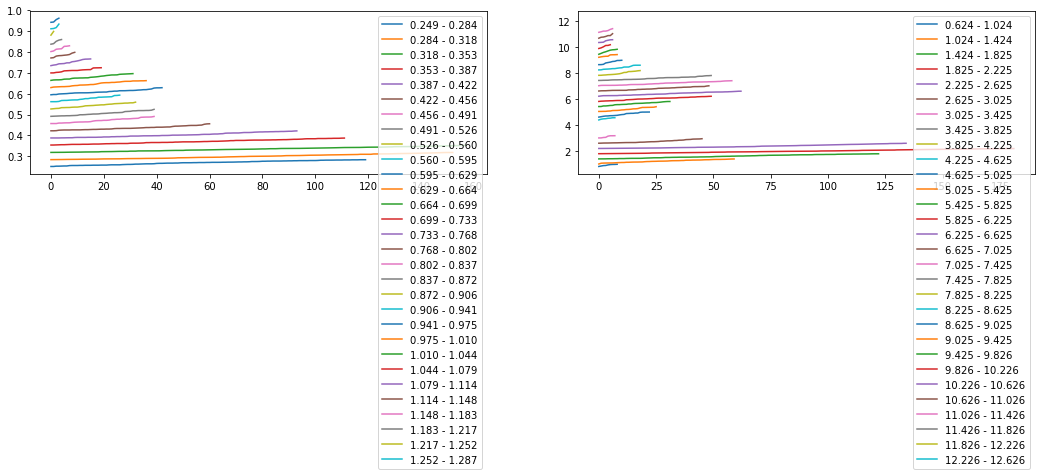

In [347]:
bin_scores_np = []
fig = plt.figure(figsize=(18,3))
ax1 = fig.add_subplot(121)
for idx, bin_set in enumerate(vol_bin_sets):
    bin_scores = []
    for b in bin_set:
        bin_scores.append(b[1])
    b_np = np.array(bin_scores)
    ax1.plot(b_np, label="%.3f - %.3f" % (vol_bin_ranges[idx][0], vol_bin_ranges[idx][1]))
    bin_scores_np.append(b_np)
ax1.legend(loc='best')

ax2 = fig.add_subplot(122)
for idx, bin_set in enumerate(vel_bin_sets):
    bin_scores = []
    for b in bin_set:
        bin_scores.append(b[1])
    b_np = np.array(bin_scores)
    ax2.plot(b_np, label="%.3f - %.3f" % (vel_bin_ranges[idx][0], vel_bin_ranges[idx][1]))
    bin_scores_np.append(b_np)
ax2.legend(loc='best')
plt.show()

0.266271 - 1.269242


/Users/trafferty/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


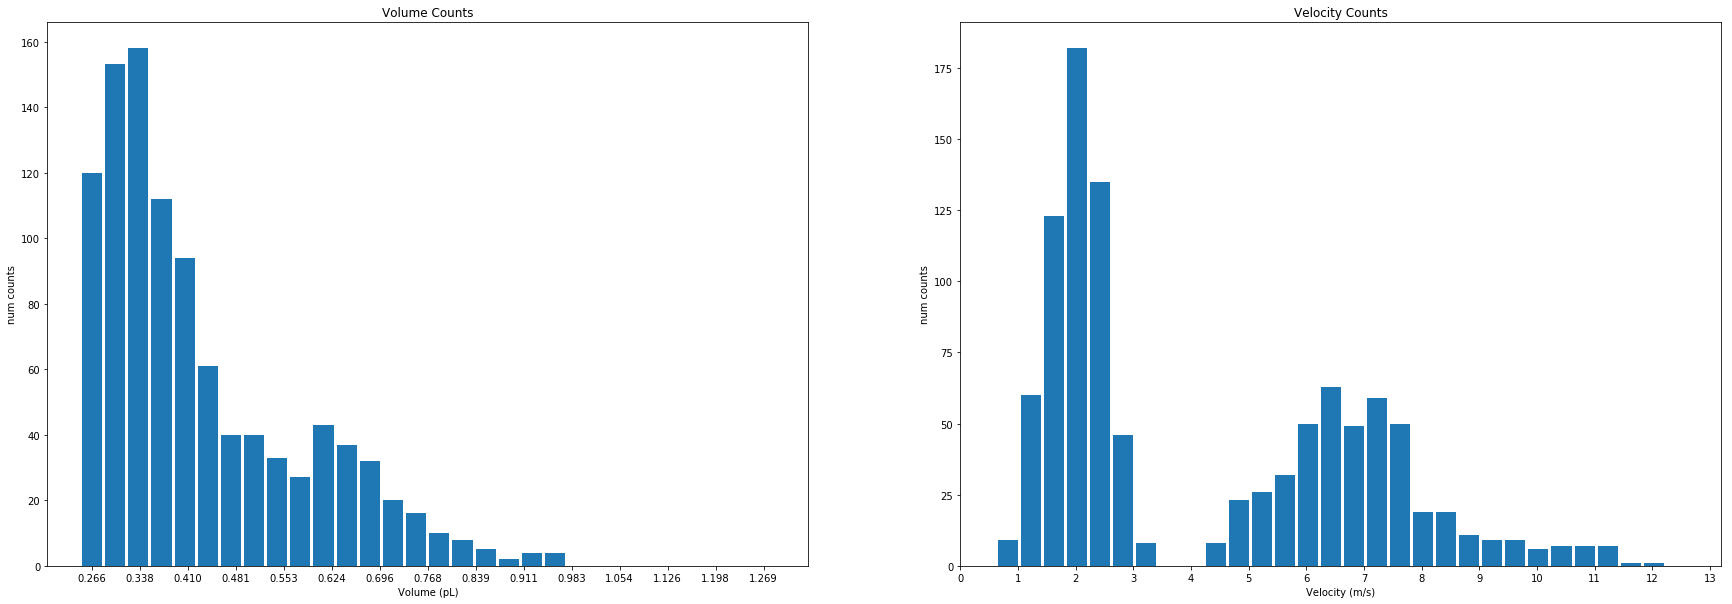

[120, 153, 158, 112, 94, 61, 40, 40, 33, 27, 43, 37, 32, 20, 16, 10, 8, 5, 2, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[9, 60, 123, 182, 135, 46, 8, 0, 0, 8, 23, 26, 32, 50, 63, 49, 59, 50, 19, 19, 11, 9, 9, 6, 7, 7, 7, 1, 1, 0]


In [348]:
plt.clf()
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

print("%f - %f" % (vol_hist_bins[0], vol_hist_bins[-1]))

ax1.bar(vol_hist_bins, vol_bin_set_counts, ((vol_hist_bins[-1] - vol_hist_bins[-0])/bin_cnt)*.9 )
ax1.set(title="Volume Counts", ylabel="num counts", xlabel="Volume (pL)")
ax1.xaxis.set(ticks=np.linspace(vol_hist_bins[0], vol_hist_bins[-1], bin_cnt/2))

ax2.bar(vel_hist_bins, vel_bin_set_counts, ((vel_hist_bins[-1] - vel_hist_bins[-0])/bin_cnt)*.9)
ax2.set(title="Velocity Counts", ylabel="num counts", xlabel="Velocity (m/s)")
ax2.xaxis.set(ticks=[x for x in range(0, int(vel_hist_bins[-1]+2))])
plt.show()

print(vol_bin_set_counts)
print(vel_bin_set_counts)

In [349]:
nozzle_of_interest = 250

zrange_lst = r.zrangebyscore(volume_hash, vol_min_max[0], vol_min_max[1], withscores=True)
zrange_lst_filtered = filter_list_of_res_by_nozzle(zrange_lst, nozzle_of_interest)

vol_scores = []
vol_results = []
for zrange in zrange_lst_filtered:
    vol_results.append(zrange[0])
    vol_scores.append(zrange[1])
vol_scores_np = np.array(vol_scores)

zrange_lst = r.zrangebyscore(vel_hash, vel_min_max[0], vel_min_max[1], withscores=True)
zrange_lst_filtered = filter_list_of_res_by_nozzle(zrange_lst, nozzle_of_interest)

vel_scores = []
vel_results = []
for zrange in zrange_lst_filtered:
    vel_results.append(zrange[0])
    vel_scores.append(zrange[1])
vel_scores_np = np.array(vel_scores)

In [350]:
print("Vel scores, min: %f, max: %f, mean: %f, stdev: %f" % (vel_scores_np.min(), vel_scores_np.max(), vel_scores_np.mean(), vel_scores_np.std() ))
print("Vol scores, min: %f, max: %f, mean: %f, stdev: %f" % (vol_scores_np.min(), vol_scores_np.max(), vol_scores_np.mean(), vol_scores_np.std() ))

Vel scores, min: 0.847486, max: 12.201977, mean: 4.250287, stdev: 2.708312
Vol scores, min: 0.250838, max: 0.962338, mean: 0.427442, stdev: 0.150978


In [351]:
vol_bin_set_counts_np = np.array(vol_bin_set_counts)
vel_bin_set_counts_np = np.array(vel_bin_set_counts)
print("Vel scores, min: %f, max: %f, mean: %f, stdev: %f" % (vel_bin_set_counts_np.min(), vel_bin_set_counts_np.max(), vel_bin_set_counts_np.mean(), vel_bin_set_counts_np.std() ))
print("Vol scores, min: %f, max: %f, mean: %f, stdev: %f" % (vol_bin_set_counts_np.min(), vol_bin_set_counts_np.max(), vol_bin_set_counts_np.mean(), vol_bin_set_counts_np.std() ))    

Vel scores, min: 0.000000, max: 182.000000, mean: 33.966667, stdev: 43.228450
Vol scores, min: 0.000000, max: 158.000000, mean: 33.966667, stdev: 45.972081


In [383]:
vel_max_bin = (np.argmax(vel_bin_set_counts_np) * vel_bin_size) + vel_min_max[0]
vol_max_bin = (np.argmax(vol_bin_set_counts_np) * vol_bin_size) + vol_min_max[0]

range_div = 6
#vel_desired_range = (vel_max_bin-(vel_scores_np.std()/range_div), vel_max_bin+(vel_scores_np.std()/range_div))
vel_desired_range = (6, 7.5)
vol_desired_range = (vol_max_bin-(vol_scores_np.std()/range_div), vol_max_bin+(vol_scores_np.std()/range_div))

print("Velocity range: %.3f - %.3f" % vel_desired_range)
print("Volume range  : %.3f - %.3f" % vol_desired_range)

Velocity range: 6.000 - 7.500
Volume range  : 0.293 - 0.343


/Users/trafferty/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


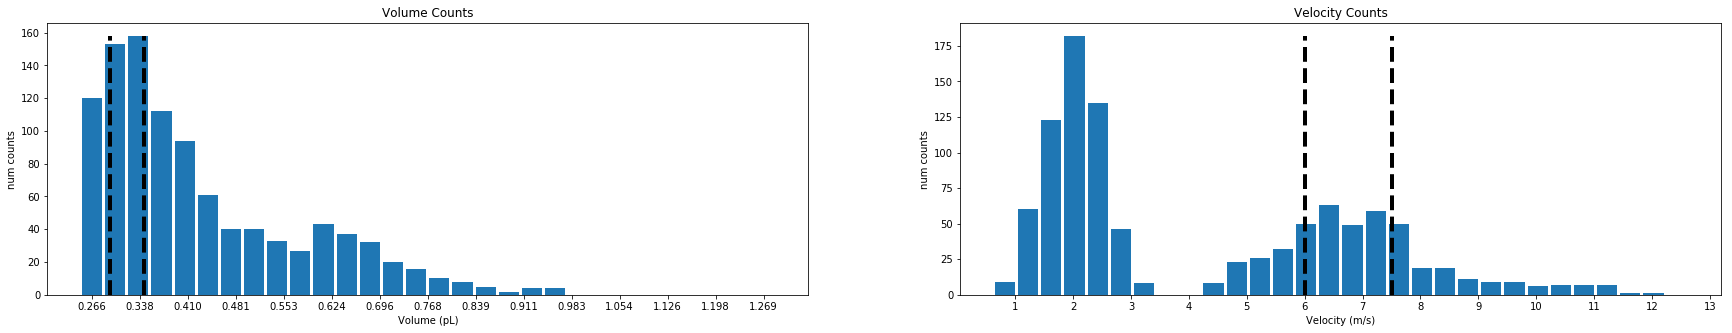

In [403]:
plt.clf()
fig = plt.figure(figsize=(30,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.bar(vol_hist_bins, vol_bin_set_counts, ((vol_hist_bins[-1] - vol_hist_bins[-0])/bin_cnt)*.9 )
ax1.set(title="Volume Counts", ylabel="num counts", xlabel="Volume (pL)")
ax1.xaxis.set(ticks=np.linspace(vol_hist_bins[0], vol_hist_bins[-1], bin_cnt/2))

ax2.bar(vel_hist_bins, vel_bin_set_counts, ((vel_hist_bins[-1] - vel_hist_bins[-0])/bin_cnt)*.9)
ax2.set(title="Velocity Counts", ylabel="num counts", xlabel="Velocity (m/s)")
ax2.xaxis.set(ticks=[x for x in range(0, int(vel_hist_bins[-1]+2))])

# vertical lines showing the desired range
max_vol = np.array(vol_bin_set_counts).max()
ax1.plot([vol_desired_range[0], vol_desired_range[0]], [0, max_vol], "k--", linewidth=4)
ax1.plot([vol_desired_range[1], vol_desired_range[1]], [0, max_vol], "k--", linewidth=4)
max_vel = np.array(vel_bin_set_counts).max()
ax2.plot([vel_desired_range[0], vel_desired_range[0]], [0, max_vel], "k--", linewidth=4)
ax2.plot([vel_desired_range[1], vel_desired_range[1]], [0, max_vel], "k--", linewidth=4)

plt.show()


In [384]:
vel_range_desired = r.zrangebyscore(vel_hash, vel_desired_range[0], vel_desired_range[1], withscores=True)
vol_range_desired = r.zrangebyscore(volume_hash, vol_desired_range[0], vol_desired_range[1], withscores=True)


In [385]:
print("len(vol_range_desired): %d" % len(vol_range_desired))
print("len(vel_range_desired): %d" % len(vel_range_desired))
print("sum                   : %d" % (len(vel_range_desired) + len(vol_range_desired)) )

len(vol_range_desired): 1668
len(vel_range_desired): 3001
sum                   : 4669


In [386]:
vel_hash_desired_zset = "%s:res_vel_set_desired" % (exp_root)
volume_hash_desired_zset = "%s:res_vol_set_desired" % (exp_root)

for vel_desired in vel_range_desired:
    r.zadd(vel_hash_desired_zset, vel_desired[1], vel_desired[0])
for vol_desired in vol_range_desired:
    r.zadd(volume_hash_desired_zset, vol_desired[1], vol_desired[0])
    

In [424]:
vol_vel_inter_hash = "%s:vol_vel_inter:%.3f-%.3f:%.3f-%.3f" % (exp_root, vol_desired_range[0], vol_desired_range[1], vel_desired_range[0], vel_desired_range[1] )
cnt = r.zinterstore(vol_vel_inter_hash, {volume_hash_desired_zset: 1, vel_hash_desired_zset: 2})
print("Created new zset: %s with %d elements" % (vol_vel_inter_hash, cnt))

Created new zset: 2017-10-02_08.42.46:1:SNX1227354:14:FF031A:vol_vel_inter:0.293-0.343:6.000-7.500 with 773 elements


In [425]:
'''
results["volume"] = str(volume)
results["vel"] = str(vel)

results["Row"] = all_vars["Row"]
results["Nozzle"] = all_vars["Nozzle"]

results["Sample Clock"] = all_vars["Sample Clock"]
results["BitmapFile"] = all_vars["BitmapFile"]
results["Global Voltage"] = all_vars["Global Voltage"]
results["PD_delay_us"] = all_vars["PD_delay_us"]
results["Waveform"] = all_vars["Waveform"]
results["Phase"] = all_vars["Phase"]
'''

'\nresults["volume"] = str(volume)\nresults["vel"] = str(vel)\n\nresults["Row"] = all_vars["Row"]\nresults["Nozzle"] = all_vars["Nozzle"]\n\nresults["Sample Clock"] = all_vars["Sample Clock"]\nresults["BitmapFile"] = all_vars["BitmapFile"]\nresults["Global Voltage"] = all_vars["Global Voltage"]\nresults["PD_delay_us"] = all_vars["PD_delay_us"]\nresults["Waveform"] = all_vars["Waveform"]\nresults["Phase"] = all_vars["Phase"]\n'

In [426]:
vol_vel_inter_lst = r.zrange(vol_vel_inter_hash, 0, -1, withscores=True)

In [427]:
res_by_waveform = {}
res_by_grid = {}

nozzle_of_interest = 250
nozzle_filter = "res:1:%d:" % nozzle_of_interest

for vol_vel_inter in vol_vel_inter_lst:
    res_hash = vol_vel_inter[0]
    inter_score = vol_vel_inter[1]
    
#     if res_hash.find(nozzle_filter) < 0:
#         continue

    res = r.hgetall(res_hash)
    
    waveform = res['Waveform']
    if waveform not in res_by_waveform:
        res_by_waveform[waveform] = {}
        res_by_waveform[waveform]['voltages'] = []
        res_by_waveform[waveform]['sample_clocks'] = []
        res_by_waveform[waveform]['PD_delay'] = []
        res_by_waveform[waveform]['results'] = []
        res_by_waveform[waveform]['score'] = []
    grid = res['BitmapFile']
    if grid not in res_by_grid:
        res_by_grid[grid] = {}
        res_by_grid[grid]['voltages'] = []
        res_by_grid[grid]['sample_clocks'] = []
        res_by_grid[grid]['PD_delay'] = []
        res_by_grid[grid]['results'] = []
        res_by_grid[grid]['score'] = []

    res_by_waveform[waveform]['voltages'].append( float(res['Global Voltage']) )
    res_by_waveform[waveform]['sample_clocks'].append( float(res['Sample Clock']) )
    res_by_waveform[waveform]['PD_delay'].append( float(res['PD_delay_us']) )
    res_by_waveform[waveform]['results'].append("vel:%.2f, vol:%.2f" % (float(res['vel']), float(res['volume'])) )
    res_by_waveform[waveform]['score'].append( inter_score )
    
    res_by_grid[grid]['voltages'].append( float(res['Global Voltage']) )
    res_by_grid[grid]['sample_clocks'].append( float(res['Sample Clock']) )
    res_by_grid[grid]['PD_delay'].append( float(res['PD_delay_us']) )
    res_by_grid[grid]['results'].append("vel:%.2f, vol:%.2f" % (float(res['vel']), float(res['volume'])) )
    res_by_grid[grid]['score'].append( inter_score )


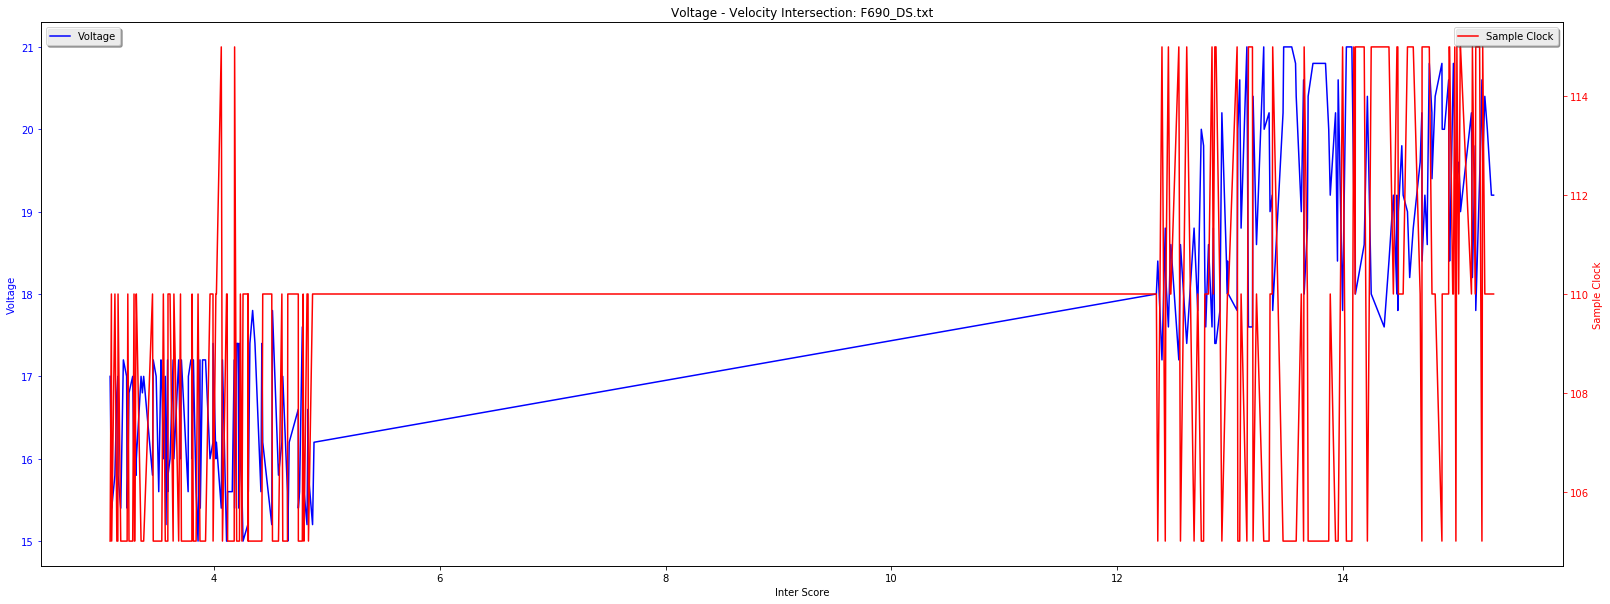

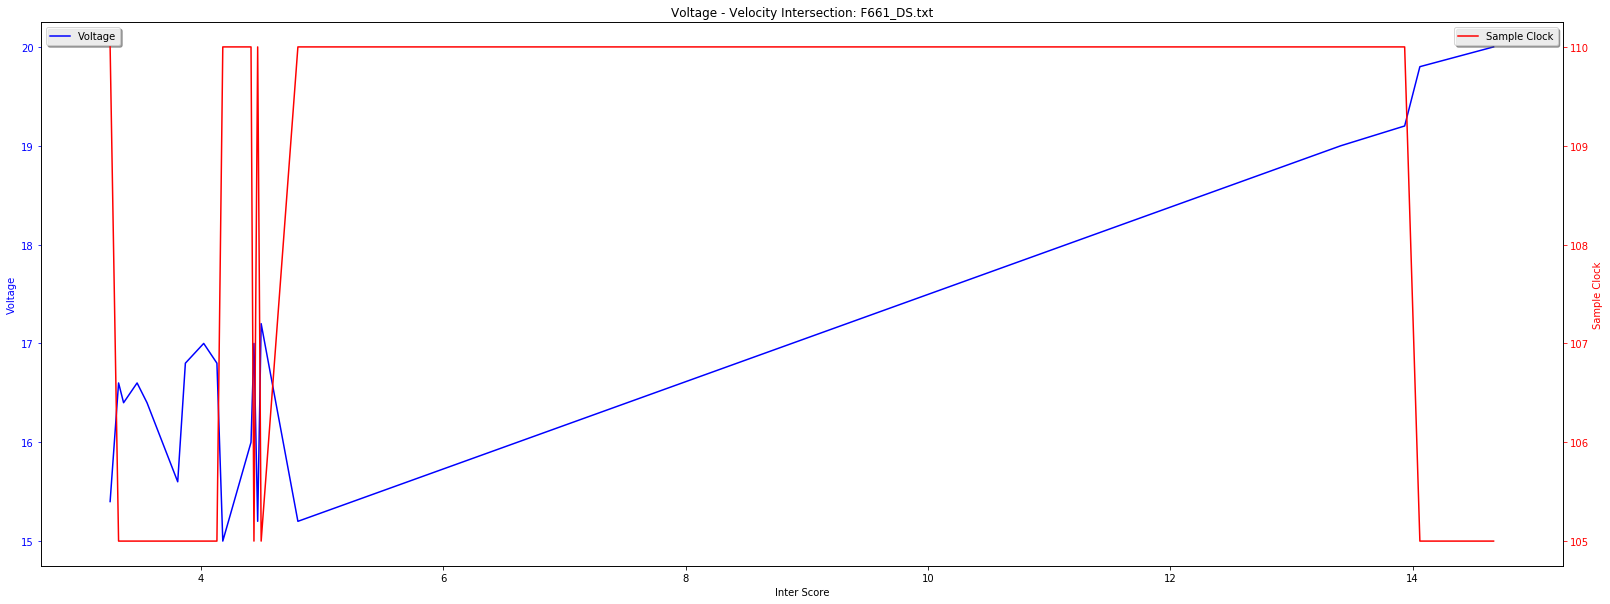

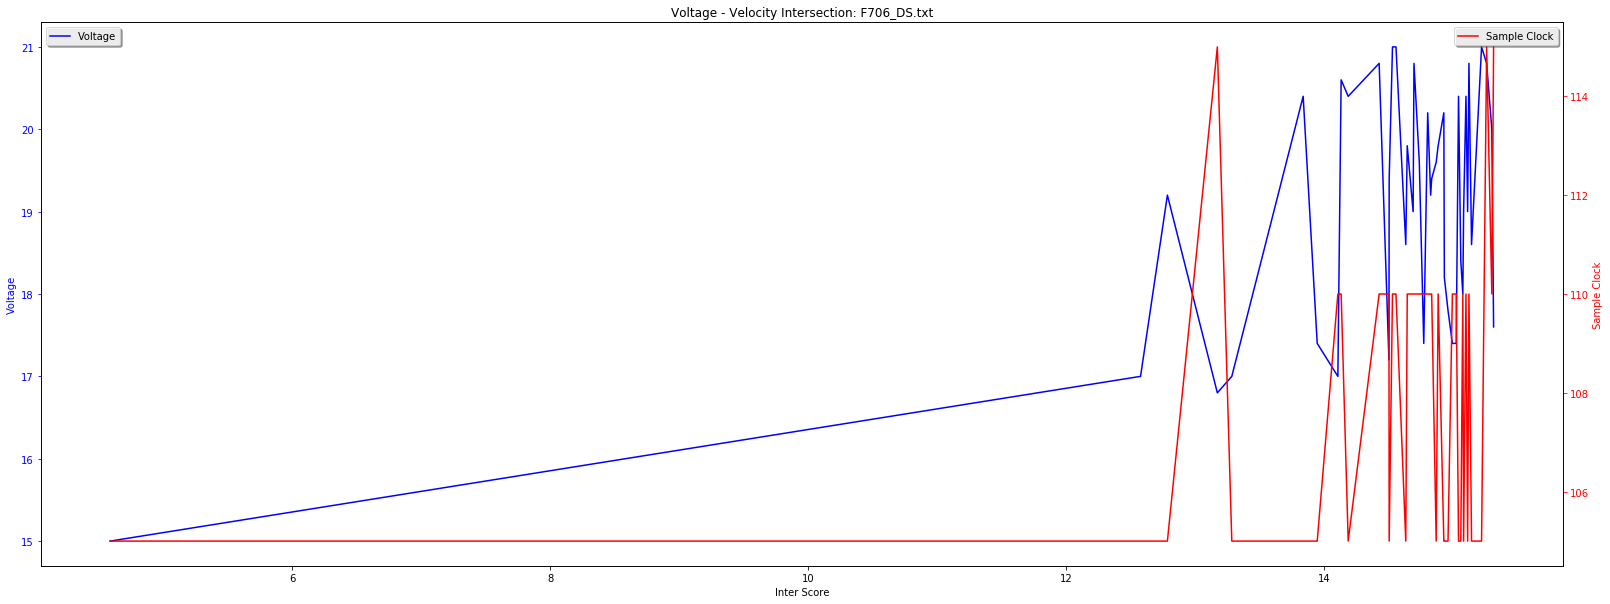

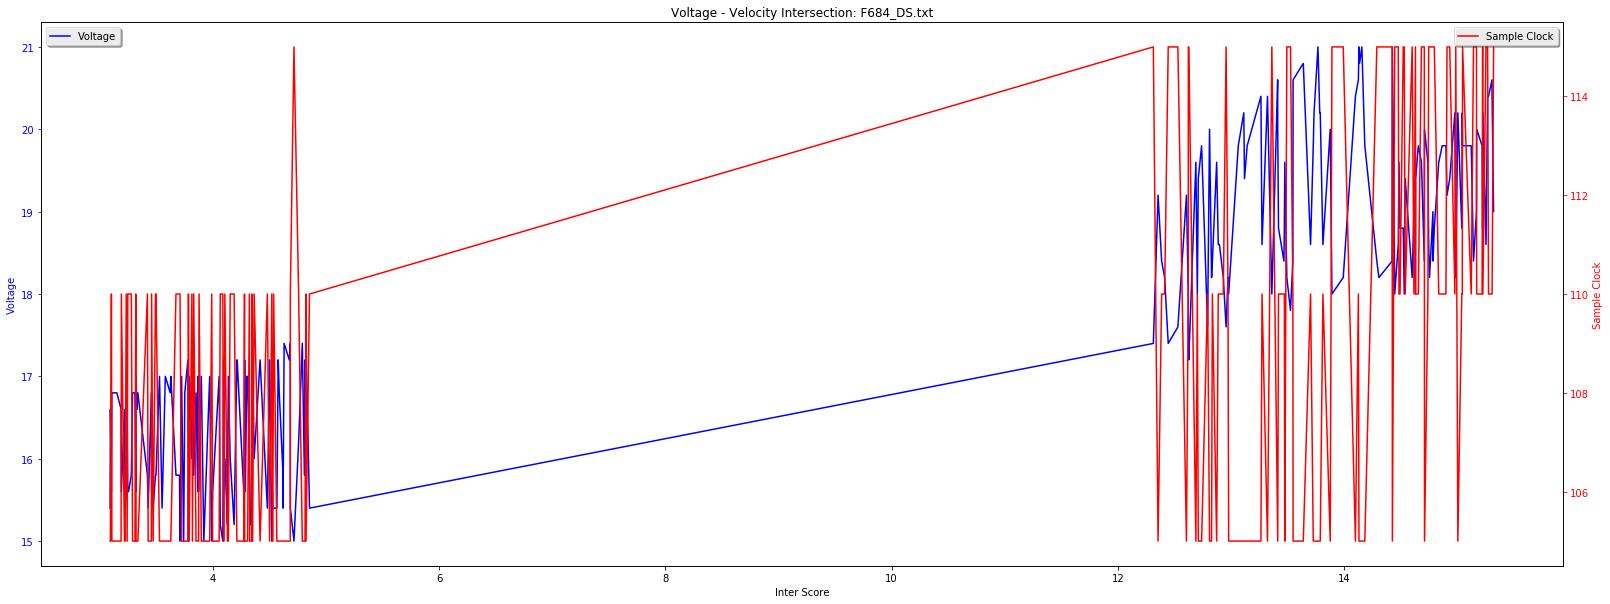

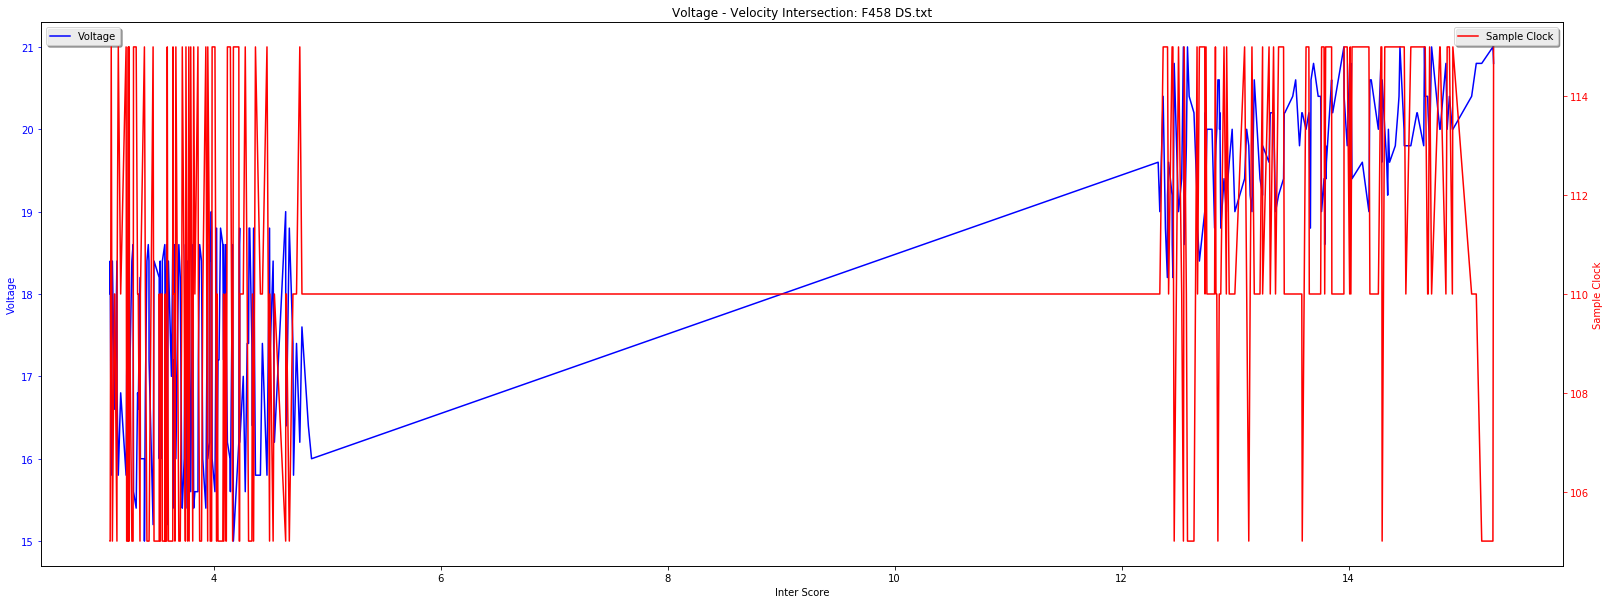

In [428]:
for waveform, res in res_by_waveform.items():    
    #waveform = 'F706_DS.txt'

    fig = plt.figure(figsize=(60,10))
    plt.clf()
    ax1 = fig.add_subplot(121)
    ax2 = ax1.twinx()

    ax1.plot(res['score'], res['voltages'],  color='b', label='Voltage')
    ax2.plot(res['score'], res['sample_clocks'],  color='r', label='Sample Clock')
    #ax2.plot(res['score'], res['PD_delay'],  color='m', label='PD Delay')

#     y_loc = np.array(res['voltages']).min()
#     for idx, lbl in enumerate(res['results']):
#         ax1.text(idx, y_loc, lbl, color='b', fontsize=8,
#                horizontalalignment='center', verticalalignment='center',
#                rotation=90, rotation_mode='anchor')

    ax1.set_xlabel('Inter Score')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Voltage', color='b')
    ax1.tick_params('y', colors='b')
    ax2.set_ylabel('Sample Clock', color='r')
    ax2.tick_params('y', colors='r')

    leg1 = ax1.legend(loc='upper left', shadow=True)
    leg2 = ax2.legend(loc='upper right', shadow=True)

    #plt.ylim([y_loc,22])
    plt.title("Voltage - Velocity Intersection: %s" % (waveform))
    #plt.tight_layout()
    plt.show()




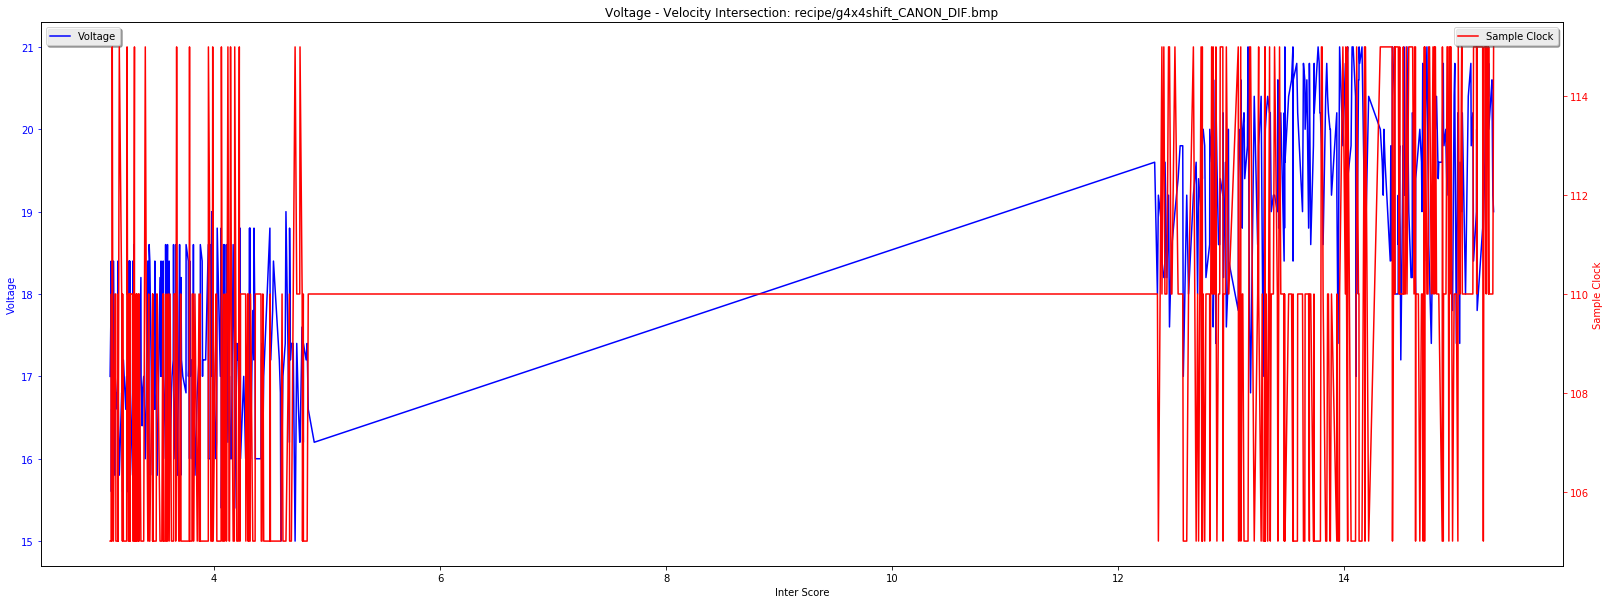

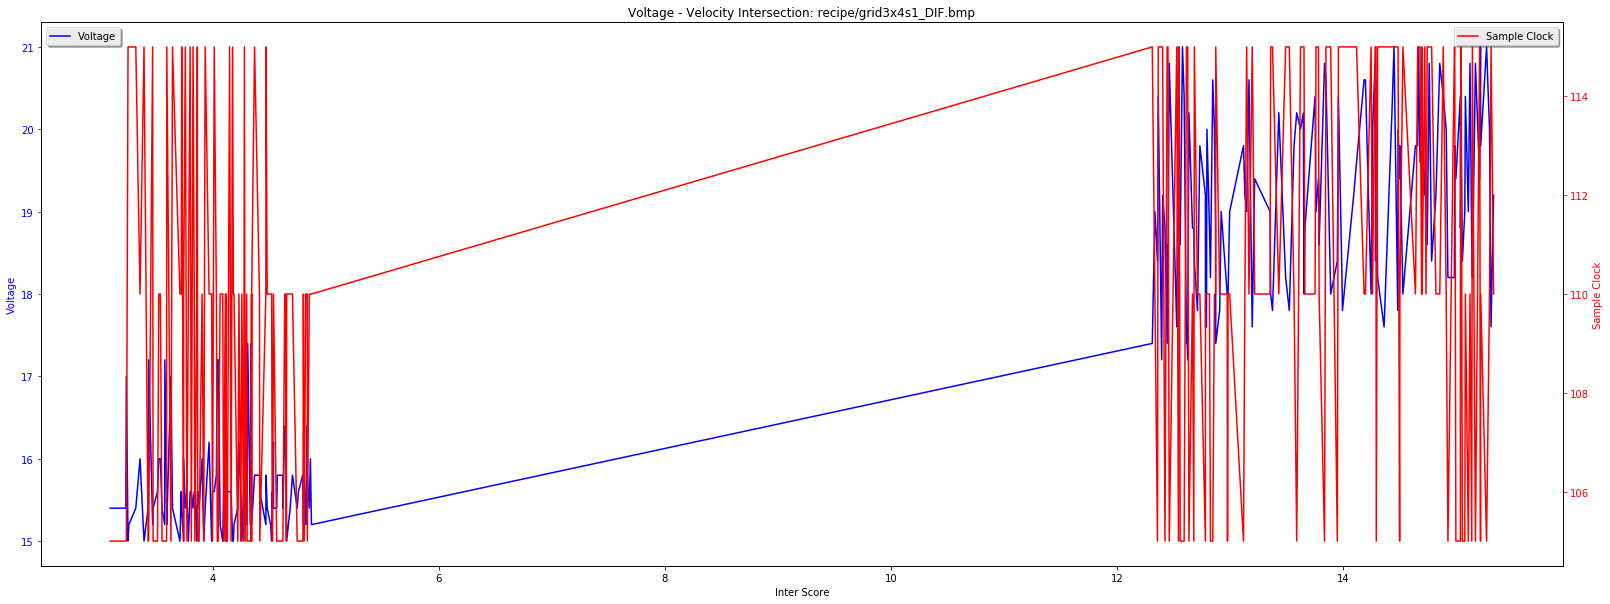

In [429]:
for grid, res in res_by_grid.items():    
    #waveform = 'F706_DS.txt'

    fig = plt.figure(figsize=(60,10))
    ax1 = fig.add_subplot(121)
    ax2 = ax1.twinx()

    ax1.plot(res['score'],res['voltages'],  color='b', label='Voltage')
    ax2.plot(res['score'],res['sample_clocks'],  color='r', label='Sample Clock')

#     y_loc = np.array(res['voltages']).min()
#     for idx, lbl in enumerate(res['results']):
#         ax1.text(idx, y_loc, lbl, color='b', fontsize=8,
#                horizontalalignment='center', verticalalignment='center',
#                rotation=90, rotation_mode='anchor')

    ax1.set_xlabel('Inter Score')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Voltage', color='b')
    ax1.tick_params('y', colors='b')
    ax2.set_ylabel('Sample Clock', color='r')
    ax2.tick_params('y', colors='r')

    leg1 = ax1.legend(loc='upper left', shadow=True)
    leg2 = ax2.legend(loc='upper right', shadow=True)

    #plt.ylim([y_loc,22])
    plt.title("Voltage - Velocity Intersection: %s" % (grid))
    #plt.tight_layout()
    plt.show()




In [296]:
_hash = vol_vel_inter_lst[2][0]
res = r.hgetall(_hash)
print("For %s: " % _hash)
res

For 2017-10-02_08.42.46:1:SNX1227354:14:FF031A:res:1:252:1178: 


{'BitmapFile': 'recipe/g4x4shift_CANON_DIF.bmp',
 'Global Voltage': '18.600000',
 'Nozzle': '252',
 'PD_delay_us': '230.000000',
 'Phase': 'C',
 'Row': '1',
 'Sample Clock': '110.000000',
 'Waveform': 'F690_DS.txt',
 'gui_image_file': '/tmp/8_tmp_dif_file.png',
 'vel': '6.2493386342425872',
 'volume': '0.30995719693895674'}

In [371]:
PD_delays = OrderedDict()

for result_hash in vol_results:
    res = r.hgetall(result_hash)
    PD_delay = int(float(res['PD_delay_us']))
    if PD_delay not in PD_delays:
        PD_delays[PD_delay] = {}
        PD_delays[PD_delay]['velocities'] = []
        PD_delays[PD_delay]['volumes'] = []
    
    PD_delays[PD_delay]['velocities'].append( float(res['vel']) )
    PD_delays[PD_delay]['volumes'].append( float(res['volume']) )


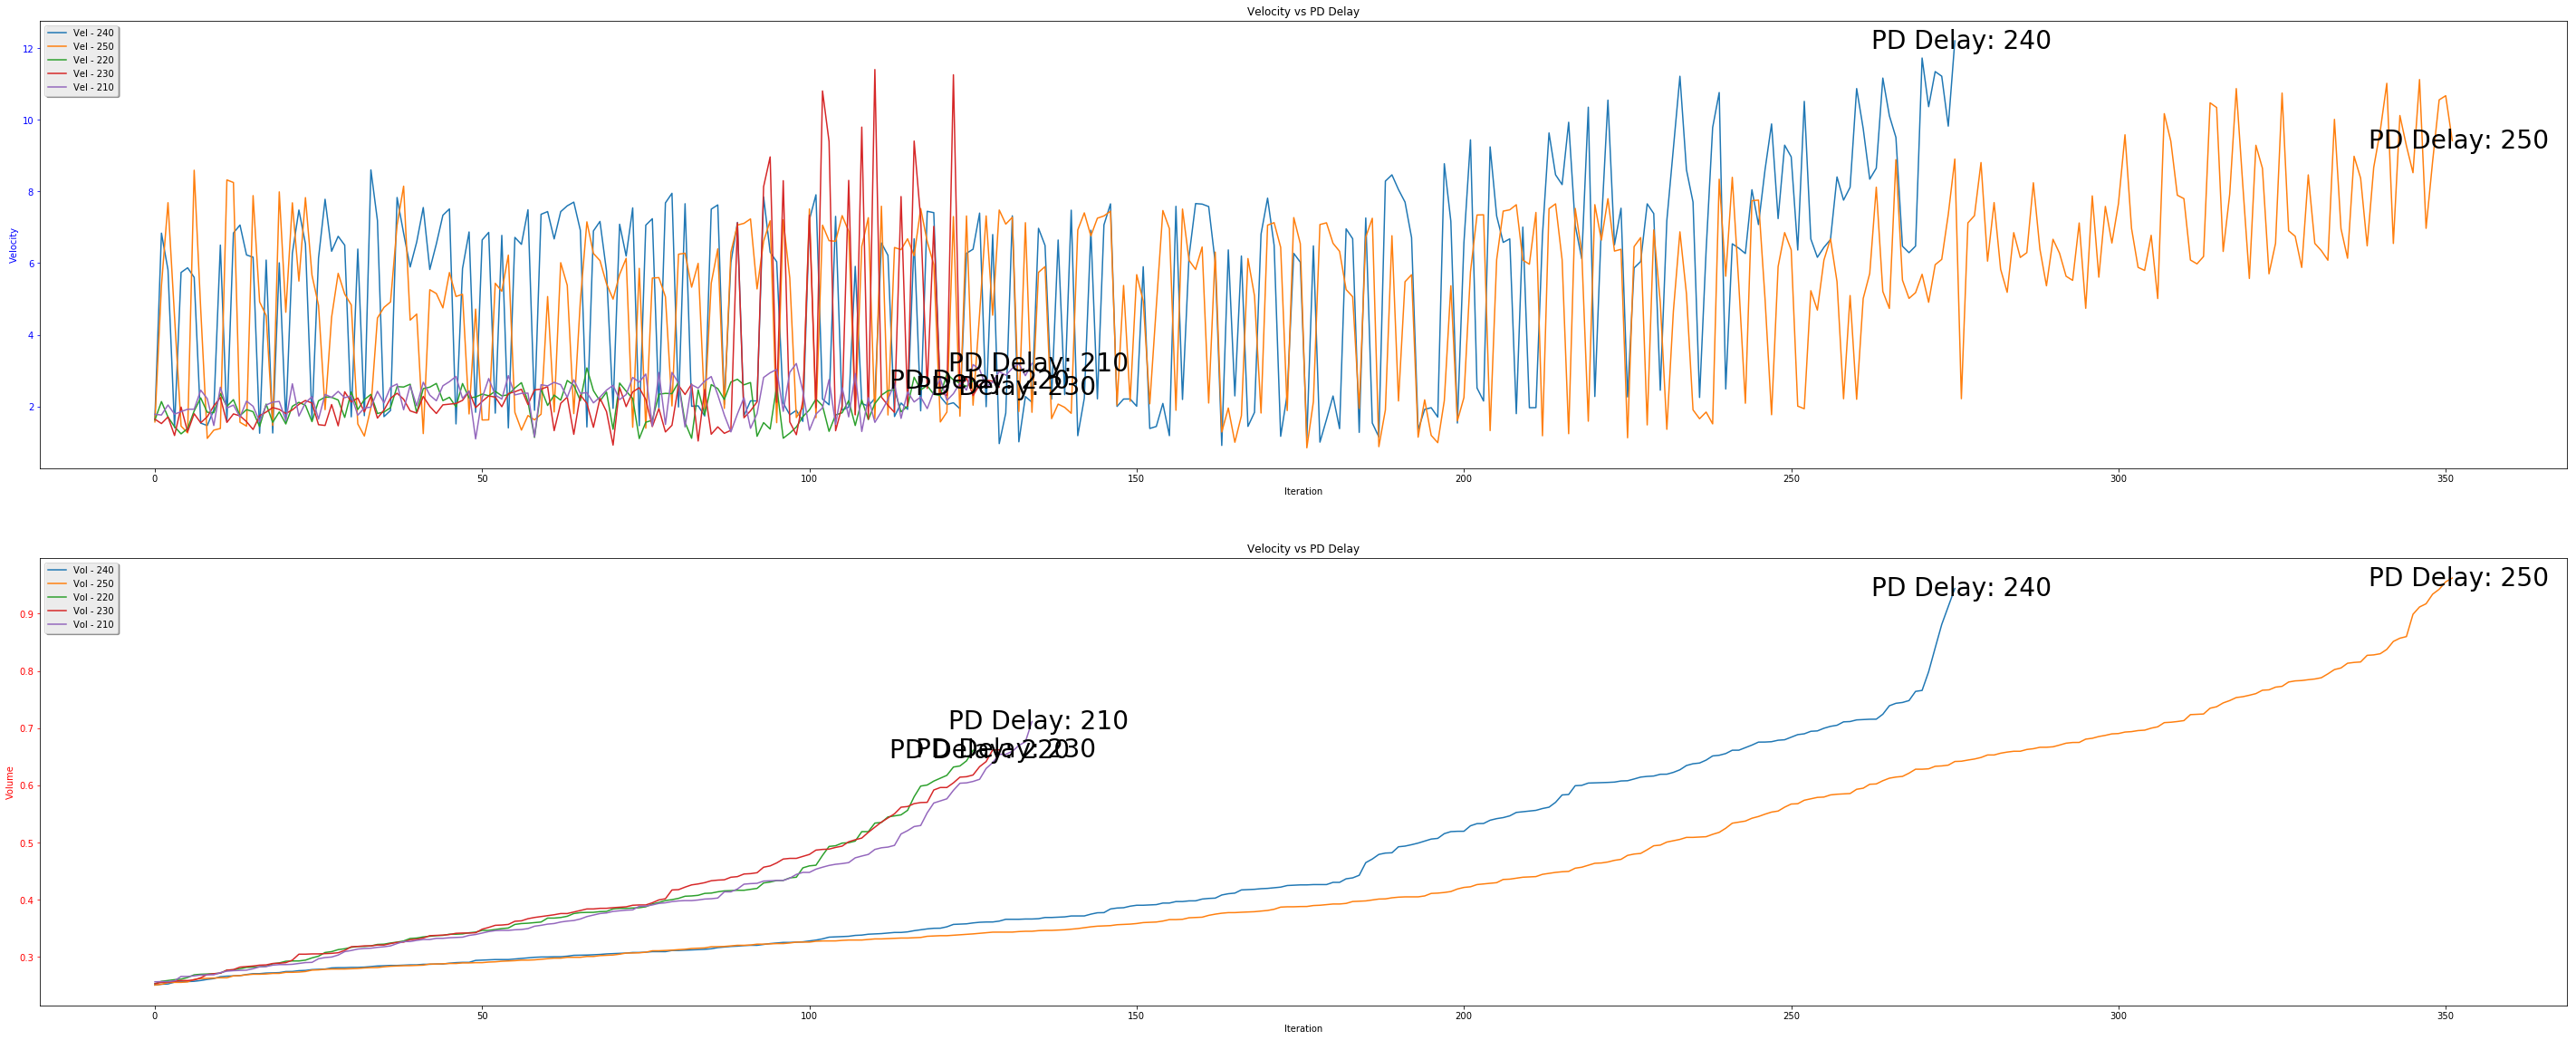

In [382]:
fig = plt.figure(figsize=(50, 20))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for PD_delay, res in PD_delays.items():    
    #waveform = 'F706_DS.txt'

    ax1.plot(res['velocities'],  label='Vel - %s' % PD_delay)
    ax2.plot(res['volumes'], label='Vol - %s' % PD_delay)

    ax1.text(len(res['velocities']), res['velocities'][-1], "PD Delay: %d" % PD_delay, fontsize=28,
           horizontalalignment='center', verticalalignment='center')

    ax2.text(len(res['volumes']), res['volumes'][-1], "PD Delay: %d" % PD_delay, fontsize=28,
           horizontalalignment='center', verticalalignment='center')

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Velocity', color='b')
    ax1.tick_params('y', colors='b')
    ax1.set_title("Velocity vs PD Delay")
    
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Volume', color='r')
    ax2.tick_params('y', colors='r')
    ax2.set_title("Velocity vs PD Delay")

leg1 = ax1.legend(loc='upper left', shadow=True)
leg2 = ax2.legend(loc='upper left', shadow=True)

#plt.ylim([y_loc,22])
#plt.title("Results by PD Delay")
#plt.tight_layout()
plt.show()

